# AI Workshop 2022/01 第7章 交差検証法
by tsuchida

> **日経平均の日足クローズ値　を使用します。**


交差検証法をカスタマイズしてより性能が高い

**[忘れないように：　そろそろライブラリを別にしないと！]**

### 前処理　以下のデータ取得して整形しています　　日経　ダウンロードセンターより

参照：https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv
 

ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from datetime import datetime

import requests
import io

データの取得と整形

In [2]:
# データダウンロード
url = 'https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv'
res = requests.get(url)
df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",")

# データを整形
df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})
df_tmp = df_tmp.rename(columns={df_tmp.columns[1]: 'Close'})
df_tmp = df_tmp.drop(0, axis=0)
df_tmp = df_tmp.drop(1, axis=0)
df_tmp = df_tmp[:-1]
print(df_tmp)

close = pd.Series(df_tmp['Close'].tolist(), index=pd.to_datetime(df_tmp['Date']).tolist())
close = close[:].astype(float)
print(close)

           Date     Close        始値        高値        安値
2    2019/01/08  20204.04  20224.67  20347.92  20106.36
3    2019/01/09  20427.06  20366.30  20494.35  20331.20
4    2019/01/10  20163.80  20270.88  20345.92  20101.93
5    2019/01/11  20359.70  20296.45  20389.89  20294.74
6    2019/01/15  20555.29  20264.82  20571.28  20204.43
..          ...       ...       ...       ...       ...
732  2022/01/07  28478.56  28711.53  28813.09  28293.70
733  2022/01/11  28222.48  28380.90  28473.47  28089.49
734  2022/01/12  28765.66  28449.53  28814.31  28427.60
735  2022/01/13  28489.13  28658.22  28660.45  28444.96
736  2022/01/14  28124.28  28246.99  28252.96  27889.21

[735 rows x 5 columns]
2019-01-08    20204.04
2019-01-09    20427.06
2019-01-10    20163.80
2019-01-11    20359.70
2019-01-15    20555.29
                ...   
2022-01-07    28478.56
2022-01-11    28222.48
2022-01-12    28765.66
2022-01-13    28489.13
2022-01-14    28124.28
Length: 735, dtype: float64


グラフ表示処理初期値の設定

In [3]:
# グラフ表示の初期値の設定
ymin = 99
ymax = 122
sxmin='2016-01-01'
sxmax=close.index.max().strftime('%Y-%m-%d')
xmin = datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.strptime(sxmax, '%Y-%m-%d')
figure_size = (22, 8)


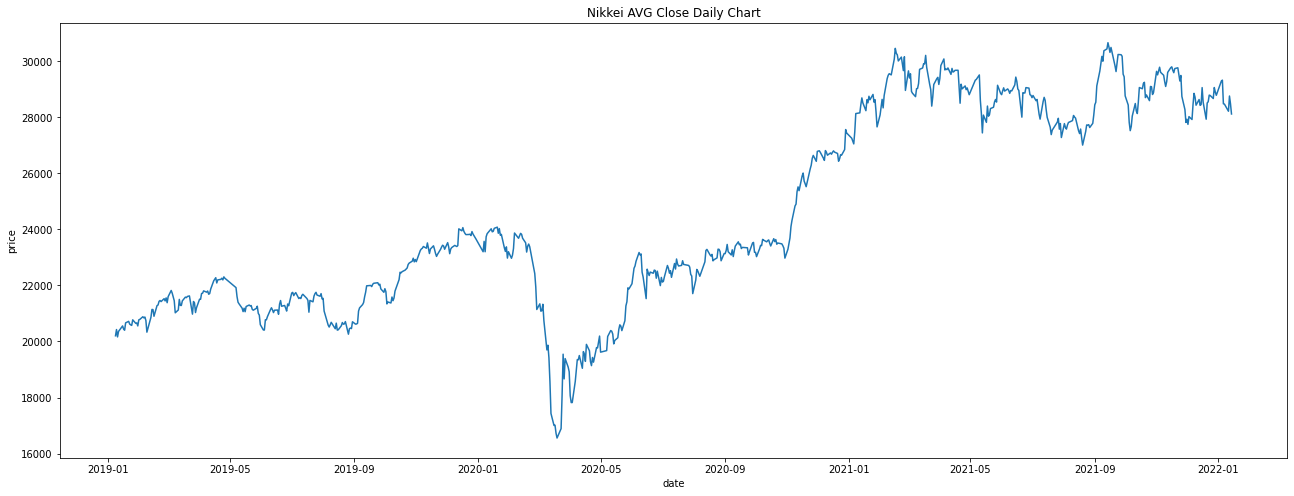

In [4]:
plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.title("Nikkei AVG Close Daily Chart")
plt.xlabel('date')
plt.ylabel('price')

plt.show()

## 第３章 ラベリング 





### Functionの紹介


#### CUSUMフィルタ
前日と当日のレートの差をとり、売買いずれかの方向それぞれに差を蓄積し、 閾値を超えた場合にイベントとしてそのデータの日付を返す

input : close = 日足の終値(pandas Series), h=閾値(float)

output : tEvent = 閾値を超えた日付の配列(list)

In [5]:
# =======================================================
# Symmetric CUSUM Filter [2.5.2.1]
def getTEvents(gRaw, h):
    """cusum filter
    args
    ----
        gRaw: array-like
        h: int() or float()
    returns
    -------
        pd.DatetimeIndex()
    """
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna().abs()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break

        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

#### 日次ボラティリティ
指定した区間の日足の情報のボラティリティを計算して値を出力する

指数加重移動平均を使った標準偏差の値が出力される

<指数加重移動平均> 重みは指数関数的に減少するので、最近のデータを重視するとともに古いデータを完全には切り捨てない

input : close = 日足の終値(pandas Series) span0=ボラティリティを求める期間(int)

output : df0 = 日次ボラティリティ(dataframe)

In [6]:
# =======================================================
# Daily Volatility Estimator [3.1]
## for wtvr reason dates are not aligned for return calculation
## must account for it for computation

def getDailyVol(close,span0=10):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

#### 時間バリア　Function　

**トリプルバリアの有効期限を取得する**

> input  : tEvents = イベント日付(トリプルバリアの起点) ,close = 日足の終値(pandas Series), numDays=イベント発生した後の有効期限(int)

> output : t1 = トリプルバリアの時間の有効期限(dataframe)

In [7]:
# =======================================================
# Adding Vertical Barrier [3.4]
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1


#### トリプルバリア　Function : getEventsOld

メタラベリングなし(売買しない判断なし)

**トリプルバリア法で売買ラベリングを取得する**

> input : close=日足の終値(pandas Series)  , tEvents=CUSUMフィルタで求めた日付の配列(list) , ptSl=上下バリアの閾値(list) , trgt=日次ボラティリティ(dataframe) , minRet= , numThreads=スレッドの数(int), t1=トリプルバリアの有効期限の値(dataframe)

> output : out=トリプルバリア(dataframe)

In [8]:
# =======================================================
# Triple-Barrier Labeling Method [3.2]
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)

    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

In [9]:
# ****. トリプルバリア Function メタラベリングなし*****
# =======================================================
# Gettting Time of First Touch (getEvents) [3.3]
def getEventsOld(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
      t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    side_=pd.Series(1.,index=trgt.index)
    
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl)
    #print(type(df0))
    events['t1']=df0.dropna(how='all').min(axis=1) 
    events=events.drop('side',axis=1)
    return events

#### トリプルバリアで利用するFunction

In [10]:
# =======================================================
# multiprocessing snippet [20.7]
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)

    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out

    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [11]:
# =======================================================
# Linear Partitions [20.4.1]
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [12]:
# =======================================================
# single-thread execution for debugging [20.8]
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

In [13]:
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

In [14]:
# =======================================================
# Unwrapping the Callback [20.10]
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

#### サイドとサイズのラベリング　Function：getBinsOld

**サイドとサイズのラベリングを取得する**
(売買しない判断なし)

> input : events=トリプルバリアの情報(dataframe), close=日足の終値(pandas Series)

> output : out=サイドとサイズのラベリングデータ(dataframe)

In [15]:
# =======================================================
# Expanding getBins to Incorporate Meta-Labeling [3.5]
def getBinsOld(events, close):
    '''
    Compute event's outcome.
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    return out

#### 不要なラベルの削除　Function：dropLabels

**サイズとサイドのラベリングで取得した値から閾値により小さいラベルを削除する**

> input : events=サイドとサイズのラベリング(dataframe) minPct=削除するための閾値

> output : out=削除後のサイドとサイズのラベリングデータ(dataframe)

In [16]:
# =======================================================
# Dropping Unnecessary Labels [3.8]
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        #print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

#### トリプルバリア　Function：getEvents

メタラベリングあり(売買しない判断あり)

**トリプルバリア法で売買ラベリングを取得する**

> input : close=日足の終値(pandas Series)  , tEvents=CUSUMフィルタで求めた日付の配列(list) , ptSl=上下バリアの閾値(list) , trgt=日次ボラティリティ(dataframe) , minRet= , numThreads=スレッドの数(int), t1=トリプルバリアの有効期限の値,side=トリプルバリアで求めた売買の情報(dataframe)

> output : out=トリプルバリア(dataframe)

In [17]:
# =======================================================
# Gettting Time of First Touch (getEvents) [3.6]
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads,t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
      t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1 
    #print("target:")
    #print(type(trgt.index))
    #print(trgt.index)

    if side is None:
      side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
      side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) #pd.min ignores nan
    
    if side is None:
      events=events.drop('side',axis=1)

    return events
# =======================================================

#### サイドとサイズのラベリング　Function：getBins

**サイドとサイズのラベリングを取得する (売買しない判断なし)**

> input : events=トリプルバリアの情報(dataframe), close=日足の終値(pandas Series)

> output : out=サイドとサイズのラベリングデータ(dataframe)

In [18]:
# =======================================================
# Labeling for side and size [3.5, 3.8]
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1

    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

## 第4章 標本の重み付け



### Functionの紹介

#### ラベルの数を数える　Function：mpNumCoEvents

ラベルの数を数える

In [19]:
# =======================================================
# Estimating uniqueness of a label [4.1]
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

#### ラベルの平均独自性の推定　Function：mpSampleTW


In [20]:
# =======================================================
# Estimating the average uniqueness of a label [4.2]
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

#### インディケータの行列の構築　Function：getIndMatrix

In [21]:
# =======================================================
# Sequential Bootstrap [4.5.2]
## Build Indicator Matrix [4.3]
def getIndMatrix(barIx,t1):
    # Get Indicator matrix
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

#### 平均独自性の計算　Function：getAvgUniqueness

In [22]:
# =======================================================
# Compute average uniqueness [4.4]
def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

#### 逐次ブートストラップからの抽出　Function：seqBootstrap

In [23]:
# =======================================================
# return sample from sequential bootstrap [4.5]
def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

#### 時間減衰　Function：getTimeDecay

In [24]:
def getTimeDecay(tW,clfLastW=1.):
  clfW=tW.sort_index().cumsum()
  if clfLastW>=0:
    slope = (1.0-clfLastW)/clfW.iloc[-1]
  else:
    slope = 1.0/((clfLastW+1)*clfW.iloc[-1])

  const = 1.0-slope*clfW.iloc[-1]

  clfW=const+slope*clfW
  clfW[clfW<0]=0
  print(const,slope)

  return clfW

#### サンプルの重み付け　Function：mpSampleW


In [25]:
# =======================================================
# Determination of sample weight by absolute return attribution [4.10]
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

##第５章 分数次差分をとった特徴量で利用したFunctionの紹介

### Functionの紹介


#### ウェイト取得　Function：getWeights




In [26]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w


####固定ウィンドウ　Function：fracDiff_FFD



In [27]:
def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w = getWeights_FFD(d,thres)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        print(width)
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width], seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            #print(f'd: {d}, iloc1:{iloc1} shapes: w:{w.T.shape}, series: {seriesF.loc[loc0:loc1].notnull().shape}')
            try:
                df_.loc[loc1]=np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df ,w

####固定ウィンドウのウェイト生成　Function：def getWeights_FFD

In [28]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)


## 検証データ作成

検証データとして、以下の内容を学習データとして、売買を予測してみる

*   メタラベリングで作成した売買のシグナル
*   分数次差分で求めた時系列データ
*   日足のクローズ



## 0 ラベリングを行う際に利用する初期値を設定する

In [29]:
# ラベリングの初期値の設定
# numDays
numDays = 1
# バリアの幅
ptsl = [ 1,1 ]
# 目標リターン
minRate = 0.01
#. 不要なラベルを削除するための閾値
minPct = 0.005
# 
cpus = 1

## 2 金融データの構造

### CUSUMフィルターでイベントを取得する

閾値はUSD/JPYレートの標準偏差を求めて利用している

CUSUMフィルターではレートの差を利用している為、単位を合わせるために値を修正



h1:
0.03512046481387124


100%|██████████| 733/733 [00:00<00:00, 16959.82it/s]

tEvents:
DatetimeIndex(['2019-01-16', '2019-01-28', '2019-02-08', '2019-02-13',
               '2019-02-20', '2019-03-04', '2019-03-08', '2019-03-15',
               '2019-03-25', '2019-03-28',
               ...
               '2021-11-19', '2021-11-26', '2021-12-01', '2021-12-07',
               '2021-12-13', '2021-12-17', '2021-12-21', '2021-12-30',
               '2022-01-06', '2022-01-13'],
              dtype='datetime64[ns]', length=149, freq=None)
close event:735
csum  event:149


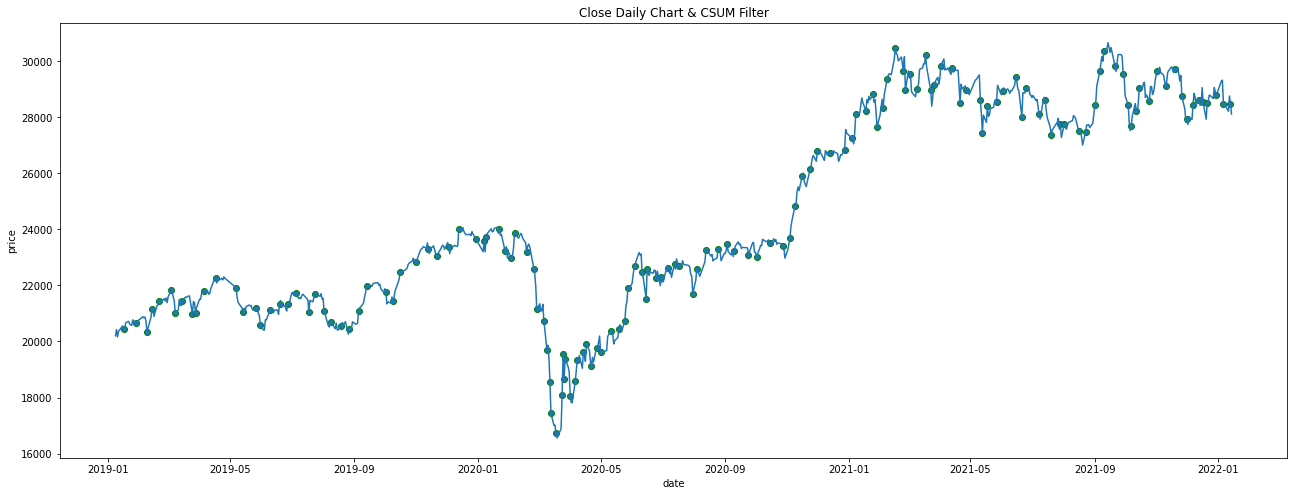

In [30]:
#CSUMフィルターの閾値としてレートの標準差を利用してするための処理
h1 = close.std()/100000
print("h1:")
print(h1)

# CUSUMフィルター　閾値を超えた時をイベントとして取得する
tEvents = getTEvents(close,h=h1)
print("tEvents:")
print(tEvents)
#print(type(tEvents))

cusum_price = close[close.index.isin(tEvents)]
#print("cusum_price:")
#print(cusum_price)

print("close event:" + str(len(close.index)))
print("csum  event:" + str(len(cusum_price.index)))

plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.title("Close Daily Chart & CSUM Filter")
plt.xlabel('date')
plt.ylabel('price')

plt.show()

## 3 ラベリング

### 日次ボラティリティと垂直バリア情報を取得する

In [31]:
# 日次ボラティリティを計算する
dailyvola = getDailyVol(close,10)
#print("dailyvola:")
target=dailyvola[1:]
#print(target)
#print(type(target))

# 垂直バリアの情報を追加する
t1 = addVerticalBarrier(tEvents,close,numDays=3)

print(t1)


2019-01-16   2019-01-21
2019-01-28   2019-01-31
2019-02-08   2019-02-12
2019-02-13   2019-02-18
2019-02-20   2019-02-25
                ...    
2021-12-13   2021-12-16
2021-12-17   2021-12-20
2021-12-21   2021-12-24
2021-12-30   2022-01-04
2022-01-06   2022-01-11
Length: 148, dtype: datetime64[ns]


### 売買をラベリングする

close event:735
cusum event:149
buy   event:66
sell  event:50


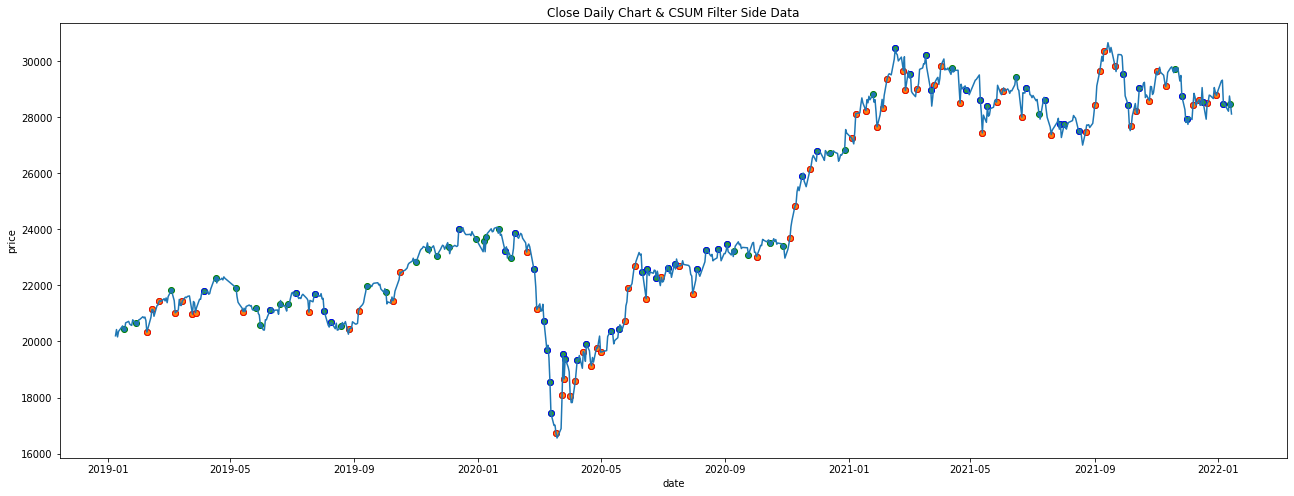

In [32]:
# トリプルバリアのイベントを取得する
events = getEventsOld(close,tEvents,ptsl,target,minRate,cpus,t1=t1)
#print("events:")
#print(events)

# 売買の方向を示す　メタラベリングがないパターン
labels = getBinsOld(events,close)
#print("labels:")
#print(labels)
#print(type(labels))

# 不要なラベリングの削除
clean_labels = dropLabels(labels,minPct)
event_price = close[close.index.isin(clean_labels.index)]

clean_labels_buy = clean_labels.query('bin == 1')
event_price_buy = close[close.index.isin(clean_labels_buy.index)]
#print("event_price_buy:")
#print(clean_labels_buy)

clean_labels_sell = clean_labels.query('bin == -1')
event_price_sell = close[close.index.isin(clean_labels_sell.index)]
#print("event_price_sell:")
#print(clean_labels_sell)

print("close event:" + str(len(close.index)))
print("cusum event:" + str(len(cusum_price.index)))
print("buy   event:" + str(len(event_price_buy.index)))
print("sell  event:" + str(len(event_price_sell.index)))

# グラフ表示
plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.scatter(event_price_buy.index, event_price_buy[:],edgecolors="red")
plt.scatter(event_price_sell.index, event_price_sell[:],edgecolors="blue")
plt.title("Close Daily Chart & CSUM Filter Side Data")
plt.xlabel('date')
plt.ylabel('price')

plt.show()

### メタラベリング

取引を行うか行わないかをラベリングする

cusum event:149
buy   event:66
sell  event:50
done  event:116


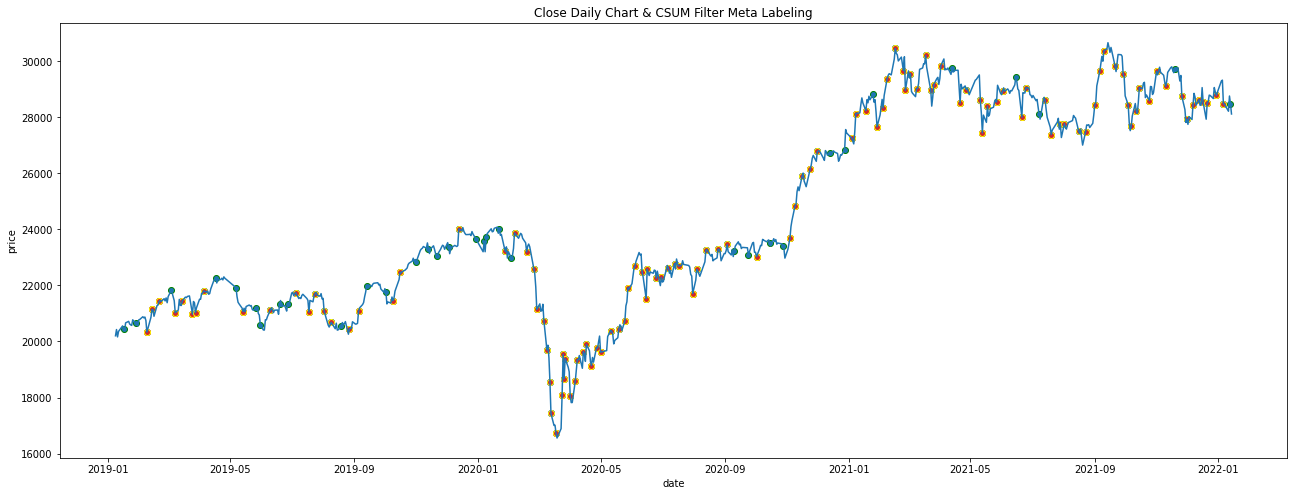

In [33]:
side = labels.bin
#print("side:")
#print(side)
#print(type(side))

# トリプルバリアのイベントを取得する
events_meta = getEvents(close,tEvents[:-1],ptsl,target,minRate,cpus,t1=t1,side=side)
#print("events_meta:")
#print(events_meta)

# 売買の方向を示す メタラベリングがないパターン
labels_meta = getBins(events_meta,close)
#print("labels_meta:")
#print(labels_meta)

clean_labels_meta = dropLabels(labels_meta,minPct)
#print("clean_labels_meta:")
#print(clean_labels_meta)

clean_labels_done = clean_labels_meta.query('bin == 1.0')
evnet_price_done = close[close.index.isin(clean_labels_done.index)]
#print("evnet_price_done:")
#print(clean_labels_done)

print("cusum event:" + str(len(cusum_price.index)))
print("buy   event:" + str(len(event_price_buy.index)))
print("sell  event:" + str(len(event_price_sell.index)))
print("done  event:" + str(len(evnet_price_done.index)))

plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.scatter(cusum_price.index, cusum_price[:],edgecolors="green")
plt.scatter(event_price_buy.index, event_price_buy[:],edgecolors="red")
plt.scatter(event_price_sell.index, event_price_sell[:],edgecolors="blue")
plt.scatter(evnet_price_done.index, evnet_price_done[:],edgecolors="yellow")
plt.title("Close Daily Chart & CSUM Filter Meta Labeling")
plt.xlabel('date')
plt.ylabel('price')

plt.show()

## 4 標本の重み付け

## 5 分数次差分
分数次差分の固定ウィンドウで、時系列データの0.6次差分を取得

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


589


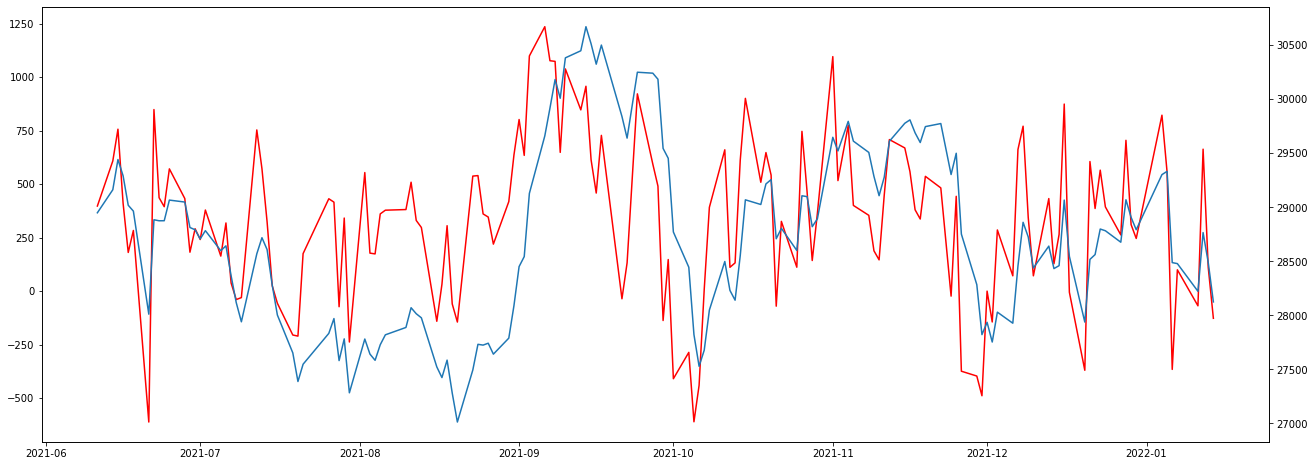

In [34]:
close_df = pd.DataFrame({'close': close})

fdiff, w = fracDiff_FFD(close_df, d=0.6)

y1 = fdiff['close']
y2 = close_df['close'].iloc[(len(w) - 1):]
x = close_df.index[(len(w) - 1):]

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(x, y1, color="red")
ax2.plot(x, y2)
plt.show()


## 6 アンサンブル法

### 1 データ前処理


 One-Hot表現に変更する Function：enc

In [57]:
# One-Hot表現に変換する関数
def enc(df, column):
  df_dummy = pd.get_dummies(df[column],prefix=column)

  df_drop = df.drop([column], axis=1)

  df1 = pd.concat([df_drop,df_dummy], axis=1)
  
  return df1

### 2 取得データを結合して　学習データと教師データ、訓練データと検証データに分割

In [58]:
print(len(close_df))

buy_data = clean_labels_buy.rename(columns={'ret': 'buyret','bin': 'buyflg'})
sell_data = clean_labels_sell.rename(columns={'ret': 'sellret','bin': 'sellflg'})
done_data = clean_labels_done.rename(columns={'ret': 'doneret','bin': 'doneflg'})
diff_data = fdiff.rename(columns={'close': 'diff'})
learndata = close_df.join([diff_data, buy_data, sell_data, done_data], how='left')

drop_col = ['buyret', 'sellret']
learndata = learndata.drop(drop_col,axis=1)
#learndata = learndata.dropna(subset=['diff'])
learndata = learndata.fillna(0)
learndata = learndata.replace( -1 , 1 )
learndata['doneflg'] = learndata['buyflg'] + learndata['sellflg']

print(learndata)

735
               close        diff  buyflg  sellflg  doneret  doneflg
2019-01-08  20204.04    0.000000     0.0      0.0      0.0      0.0
2019-01-09  20427.06    0.000000     0.0      0.0      0.0      0.0
2019-01-10  20163.80    0.000000     0.0      0.0      0.0      0.0
2019-01-11  20359.70    0.000000     0.0      0.0      0.0      0.0
2019-01-15  20555.29    0.000000     0.0      0.0      0.0      0.0
...              ...         ...     ...      ...      ...      ...
2022-01-07  28478.56   99.653987     0.0      0.0      0.0      0.0
2022-01-11  28222.48  -68.595104     0.0      0.0      0.0      0.0
2022-01-12  28765.66  663.485565     0.0      0.0      0.0      0.0
2022-01-13  28489.13  110.874867     0.0      0.0      0.0      0.0
2022-01-14  28124.28 -126.966376     0.0      0.0      0.0      0.0

[735 rows x 6 columns]


In [59]:
# 先頭5行の確認
display(learndata.head())

,close,diff,buyflg,sellflg,doneret,doneflg
2019-01-08,20204.04,0.0,0.0,0.0,0.0,0.0
2019-01-09,20427.06,0.0,0.0,0.0,0.0,0.0
2019-01-10,20163.80,0.0,0.0,0.0,0.0,0.0
2019-01-11,20359.70,0.0,0.0,0.0,0.0,0.0
2019-01-15,20555.29,0.0,0.0,0.0,0.0,0.0


In [60]:
# 欠損値チェック
learndata.isnull().sum()

close      0
diff       0
buyflg     0
sellflg    0
doneret    0
doneflg    0
dtype: int64

In [39]:
#統計情報の調査
learndata.describe()

,close,diff,buyflg,sellflg,doneret,doneflg
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,28706.985205,330.297026,0.109589,0.082192,0.002851,0.191781
std,818.320448,371.382868,0.313452,0.275602,0.007066,0.395057
min,27013.250000,-611.791375,0.000000,0.000000,0.000000,0.000000
25%,28011.952500,111.014509,0.000000,0.000000,0.000000,0.000000
50%,28707.810000,360.927718,0.000000,0.000000,0.000000,0.000000
75%,29272.282500,569.995429,0.000000,0.000000,0.000000,0.000000
max,30670.100000,1236.001158,1.000000,1.000000,0.031174,1.000000


In [61]:
# x, yへの分割
x = learndata.drop(['doneflg'], axis=1)
print(len(x))
y = learndata['doneflg'].values

y = y.astype(int)
print(y)

735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 

In [137]:
# 分割日 mdayの設定
mday = pd.to_datetime('2021-07-15')

# 訓練用indexと検証用indexを作る
train_index = learndata.index < mday
test_index = learndata.index >= mday

# 入力データの分割
x_train = x[train_index]
x_test = x[test_index]

# yも同様に分割
y_train = y[train_index]
y_test = y[test_index]

# 日付データの分割(グラフ表示用)
dates_test = learndata.index[test_index]

In [138]:
# 結果確認(サイズを確認)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(dates_test)

# 結果確認 (境界値を重点的に)
display(x_train.tail())
display(x_test.head())

(613, 5)
(122, 5)
(613,)
(122,)
DatetimeIndex(['2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30',
               ...
               '2021-12-29', '2021-12-30', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14'],
              dtype='datetime64[ns]', length=122, freq=None)


,close,diff,buyflg,sellflg,doneret
2021-07-08,28118.03,-39.354120,0.0,0.0,0.000000
2021-07-09,27940.42,-30.195819,0.0,0.0,0.000000
2021-07-12,28569.02,753.445816,0.0,0.0,0.000000
2021-07-13,28718.24,572.399331,0.0,0.0,0.000000
2021-07-14,28608.49,324.118614,0.0,1.0,0.021162


,close,diff,buyflg,sellflg,doneret
2021-07-15,28279.09,25.167189,0.0,0.0,0.000000
2021-07-16,28003.08,-56.580209,0.0,0.0,0.000000
2021-07-19,27652.74,-205.063222,0.0,0.0,0.000000
2021-07-20,27388.16,-210.185399,1.0,0.0,0.016253
2021-07-21,27548.00,175.358486,0.0,0.0,0.000000


### 3 ライブラリの読み込み

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

 ### 4 バギング

In [139]:
models = {
    'not bagging': DecisionTreeClassifier(random_state=0),
    'bagging': BaggingClassifier(DecisionTreeClassifier(random_state=0), n_estimators=100, random_state=0) 
}

scores = {}
for model_name, model in models.items():
    model.fit(x_train, y_train)
    scores[(model_name, 'train_score')] = model.score(x_train, y_train)
    scores[(model_name, 'test_score')] = model.score(x_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
bagging,1.0,1.0
not bagging,1.0,1.0


 ### 5 ブースティング

In [140]:
models = {
    'tree': DecisionTreeRegressor(random_state=0),
    'AdaBoost': AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=100, random_state=0) 
}

scores = {}
for model_name, model in models.items():
    model.fit(x_train, y_train)
    scores[(model_name, 'train_score')] = model.score(x_train, y_train)
    scores[(model_name, 'test_score')] = model.score(x_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,1.0,1.0
tree,1.0,1.0


## 7 交差検証法

### Function紹介

#### パージを行うFunction

In [141]:
def getTrainTimes(t1,testTimes):
    """
    Given testTimes, find the times of the training observations
    -t1.index: Time when the observation started
    -t1.value: Time when the observation ended
    -testTimes: Times of testing observations
    """
    trn=t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

#### エンバーゴの処理を行うFunction

In [142]:
def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg

def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg

## Examples

# testtimes=pd.Series(mbrg[dt1],index=[dt0]) # include embargo before purge
# trainTimes=getTrainTimes(t1,testTimes)
# testTimes=t1.loc[dt0:dt1].index

#### パージとエンバーゴを行う交差検証法

In [143]:
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

#### 交差検証した結果を出力する

In [144]:
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',
            t1=None,cv=None,cvGen=None,pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[idx[train],:],y=y.iloc[idx[train]],
                    sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[idx[test],:])
            score_=-log_loss(y.iloc[idx[test]], prob,
                                    sample_weight=sample_weight.iloc[idx[test]].values,
                                    labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[idx[test],:])
            score_=accuracy_score(y.iloc[idx[test]],pred,
                                  sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

### 交差検証法比較

https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/b1f980effc2fa69f7fa5b18a9407bceae2eabd12/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

RANDOM_STATE = 777
n_estimator = 1000
depth = 4

#### K 交差検証法

In [146]:
def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    

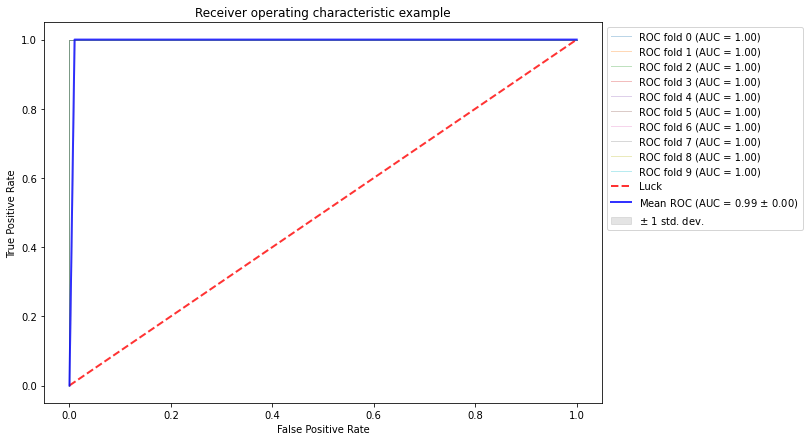

In [147]:
import warnings
warnings.filterwarnings('ignore')

skf = KFold(n_splits=10, shuffle=False)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot(skf,classifier,x,y)

#### Purge K交差検証法

In [148]:
def crossValPlot2(skf,classifier,X,y):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    print(len(X))
    print(len(y))
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

735
735


ValueError: ignored

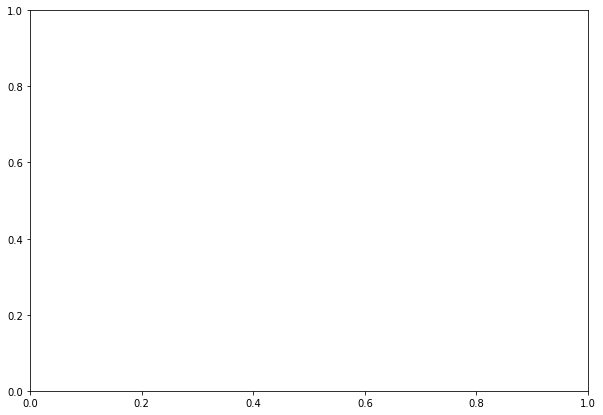

In [149]:
skf = PurgedKFold(n_splits=10,t1=t1,pctEmbargo=0.01)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth,
                                    criterion='entropy', 
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot2(skf,classifier,x,y)

In [136]:
scores = cvScore(classifier,x,y,w,t1=t1,pctEmbargo=0.01,cv=10)
scores = pd.Series(scores).sort_values()
scores

ValueError: ignored